In [1]:
import pandas as pd
from PIL import Image
import io
import json
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import cv2

In [2]:
test_data = pd.read_parquet('cord-v2/data/test-00000-of-00001-9c204eb3f4e11791.parquet')
len(test_data)

100

In [3]:
validation_data = pd.read_parquet('cord-v2/data/validation-00000-of-00001-cc3c5779fe22e8ca.parquet')
len(validation_data)

100

In [4]:
parquet_file = [
    'cord-v2/data/train-00000-of-00004-b4aaeceff1d90ecb.parquet',
    'cord-v2/data/train-00001-of-00004-7dbbe248962764c5.parquet',
    'cord-v2/data/train-00002-of-00004-688fe1305a55e5cc.parquet',
    'cord-v2/data/train-00003-of-00004-2d0cd200555ed7fd.parquet'
    ]

df = pd.concat([pd.read_parquet(f) for f in parquet_file])

In [5]:
len(df)

800

In [6]:
df.head()

,image,ground_truth
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""Nasi Campur Bal..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""SPGTHY BOLOGNAS..."
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""HAKAU UDANG"", ""..."
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""Bintang Bremer""..."
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": {""nm"": ""BASO BIHUN"", ""un..."


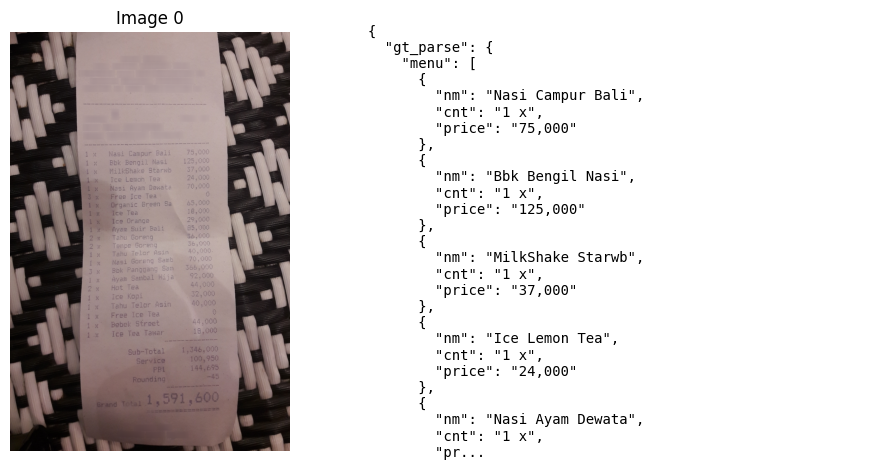

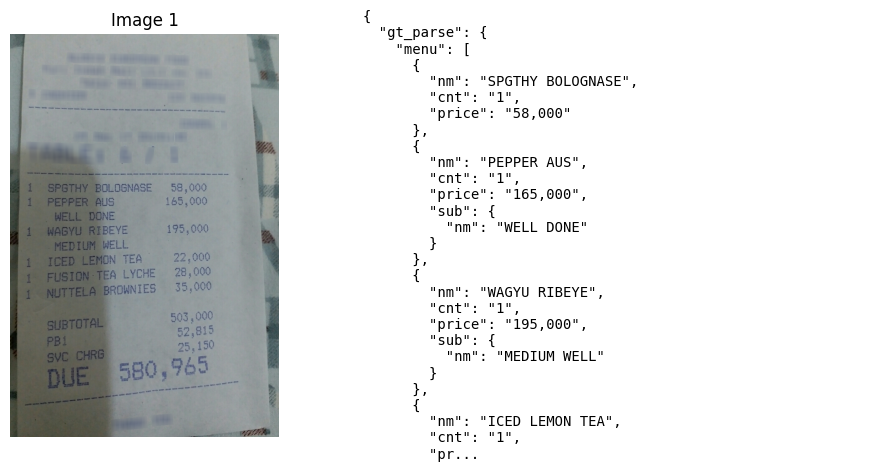

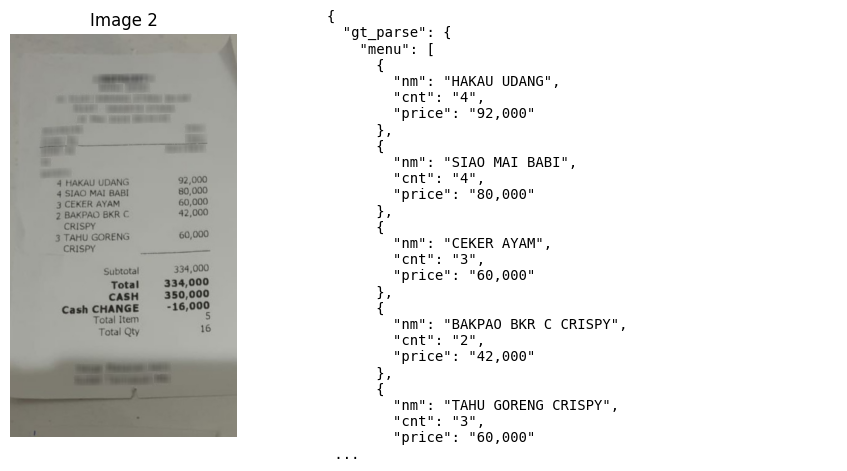

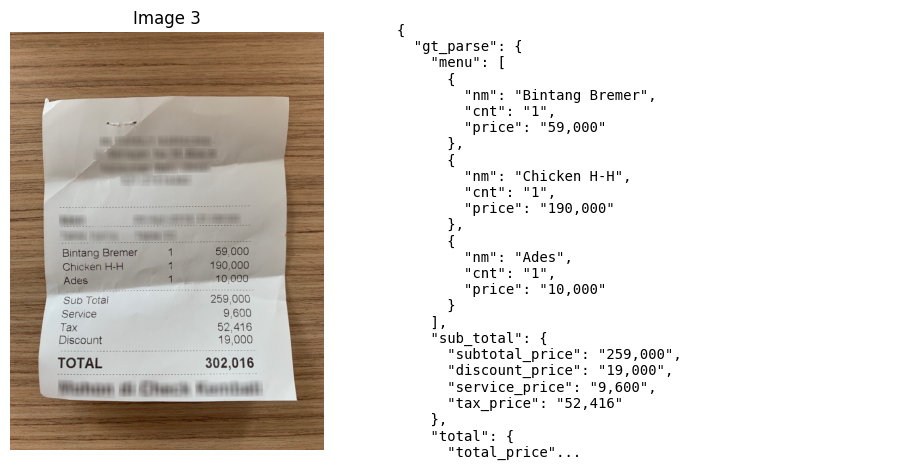

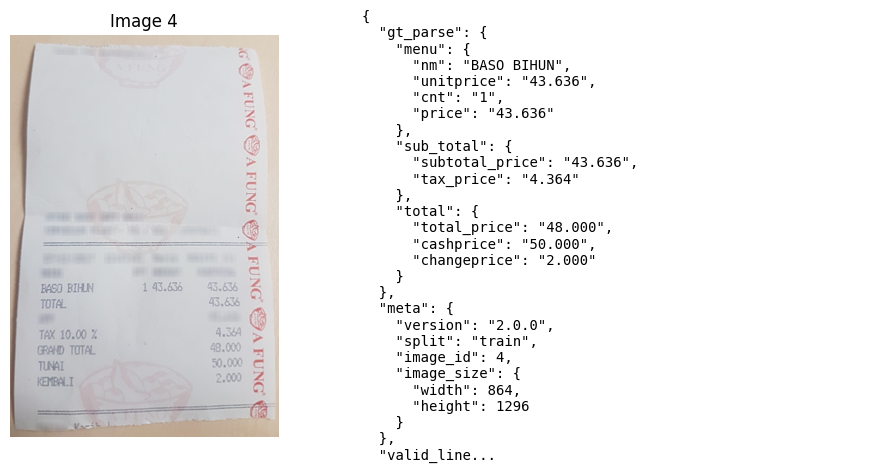

Full ground truth for image 4:
{
  "gt_parse": {
    "menu": {
      "nm": "BASO BIHUN",
      "unitprice": "43.636",
      "cnt": "1",
      "price": "43.636"
    },
    "sub_total": {
      "subtotal_price": "43.636",
      "tax_price": "4.364"
    },
    "total": {
      "total_price": "48.000",
      "cashprice": "50.000",
      "changeprice": "2.000"
    }
  },
  "meta": {
    "version": "2.0.0",
    "split": "train",
    "image_id": 4,
    "image_size": {
      "width": 864,
      "height": 1296
    }
  },
  "valid_line": [
    {
      "words": [
        {
          "quad": {
            "x2": 172,
            "y3": 836,
            "x3": 172,
            "y4": 836,
            "x1": 96,
            "y1": 800,
            "x4": 96,
            "y2": 800
          },
          "is_key": 0,
          "row_id": 2119099,
          "text": "BASO"
        },
        {
          "quad": {
            "x2": 272,
            "y3": 834,
            "x3": 272,
            "y4": 834,
       

In [7]:
for index, row in df.head(5).iterrows():
    image_data = row['image']
    image = Image.open(io.BytesIO(image_data['bytes']))
    
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display the image on the left side
    ax[0].imshow(image)
    ax[0].set_title(f"Image {index}")
    ax[0].axis('off')
    
    # Parse the ground truth JSON string to a Python object
    ground_truth = json.loads(row['ground_truth'])  # Parse JSON string to a Python dict
    formatted_gt = json.dumps(ground_truth, indent=2)  # Convert dict to pretty JSON string
    
    # Display the JSON-formatted ground truth on the right side
    truncated_gt = (formatted_gt[:500] + '...') if len(formatted_gt) > 500 else formatted_gt
    ax[1].text(0, 0.5, truncated_gt, wrap=True, fontsize=10, verticalalignment='center', 
               family='monospace', transform=ax[1].transAxes)  # Use monospace font for JSON
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()

    if index == 4:  # Change this to any other index if needed
        print(f"Full ground truth for image {index}:\n{formatted_gt}\n")

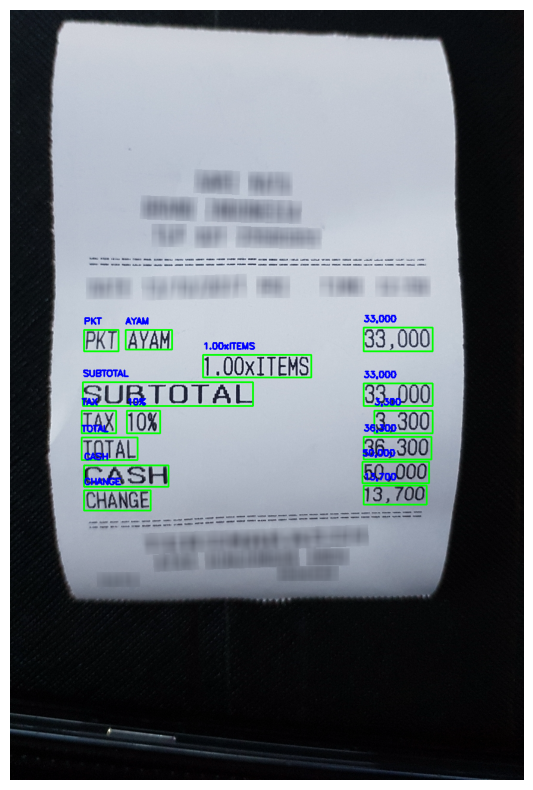

In [8]:
import numpy as np

def display_image_with_labels(image_data, label_data, box_color=(0, 255, 0), text_color=(255, 0, 0), thickness=2, font_scale=0.5):
    """
    Menampilkan gambar dengan bounding box dan label teks menggunakan Matplotlib.
    
    Parameters:
    - image_data (dict): Data gambar dalam format bytes.
    - label_data (dict): Data label dalam format dictionary, berisi koordinat bounding box dan teks.
    - box_color (tuple): Warna bounding box (BGR).
    - text_color (tuple): Warna teks (BGR).
    - thickness (int): Ketebalan garis bounding box.
    - font_scale (float): Skala ukuran font untuk teks label.
    """
    
    # Load image and convert to OpenCV format
    image = image_data
    # image = Image.open(io.BytesIO(image_data['bytes']))
    # image = np.array(image)  # Convert PIL image to NumPy array
    
    # Set font for text
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    # Parse valid_line dan buat bounding box
    for line in label_data:
        for word in line['words']:
            quad = word['quad']
            
            # Define bounding box from the quad
            top_left = (quad['x1'], quad['y1'])
            bottom_right = (quad['x3'], quad['y3'])
            
            # Draw bounding box
            cv2.rectangle(image, top_left, bottom_right, box_color, thickness)
            
            # Write text label near the box
            text = word['text']
            cv2.putText(image, text, (quad['x1'], quad['y1'] - 10), font, font_scale, text_color, thickness)
    
    # Convert BGR to RGB for displaying in matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the image with bounding boxes using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes for a cleaner look
    plt.show()

# Contoh penggunaan
index = 7
ground_truth = json.loads(df.iloc[index]['ground_truth'])  # Parse JSON string to a Python dict
image_data = df.iloc[index]['image']
image = Image.open(io.BytesIO(image_data['bytes']))
image_data = np.array(image)  
display_image_with_labels(image_data, ground_truth['valid_line'])


In [9]:
def get_dimensions(image_data):
    image = Image.open(io.BytesIO(image_data['bytes']))
    return image.size

In [10]:
df['image_dimensions'] = df['image'].apply(get_dimensions)

print(df[['image', 'image_dimensions']])

                                                 image image_dimensions
0    {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      (864, 1296)
1    {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      (864, 1296)
2    {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      (720, 1280)
3    {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...     (1108, 1478)
4    {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      (864, 1296)
..                                                 ...              ...
195  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...     (2304, 4096)
196  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      (864, 1296)
197  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...       (576, 864)
198  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...      (864, 1296)
199  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...     (1551, 2701)

[800 rows x 2 columns]


In [11]:
#augmentation


Padding

In [12]:
def preprocess_image(image) -> np.ndarray:
        """
        Memproses gambar untuk meningkatkan akurasi OCR
        """
        # Baca gambar
        image = image

        # Konversi ke grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply adaptive thresholding
        binary = cv2.adaptiveThreshold(
            gray, 
            255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 
            21, 
            10
        )
        
        # Tingkatkan kontras menggunakan CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(binary)
        
        # Sharpening menggunakan unsharp masking
        gaussian_blur = cv2.GaussianBlur(enhanced, (0, 0), 3.0)
        sharpened = cv2.addWeighted(enhanced, 1.5, gaussian_blur, -0.5, 0)
        # Reduce noise
        denoised = cv2.fastNlMeansDenoising(sharpened)
        
        return denoised

In [13]:
preprocessed_image = preprocess_image(image_data)


In [14]:
preprocessed_image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [15]:
import os
import numpy as np
from PIL import Image
# Step 1: Ensure output directory exists
output_dir = "output_images_preprocessed"
os.makedirs(output_dir, exist_ok=True)

# Step 2: Convert array to image and save
# Assuming you have multiple arrays in a list
image_arrays = [preprocessed_image]  # Replace this with your actual array list

for index, image_array in enumerate(image_arrays):
    # Convert numpy array to PIL image
    image = Image.fromarray(image_array)

    # Save the image as a PNG file
    image.save(os.path.join(output_dir, f'image_{index}.png'), format='PNG')

print(f"Images saved to {output_dir}")

Images saved to output_images_preprocessed


Using CPU. Note: This module is much faster with a GPU.


Baris yang mengandung kata 'TOTAL' dan teks sebaris:
Baris 1: Hoho 11,700 ONIGIRI 13,5C0 Subtotal 116.200 502 Disc 100 ~58 ,
Baris 2: Disc 100 8 @T Subtotal 58, 1C0 Tax 5 , TOTAL 63, ~58 , 810 910
Baris 3: Subtotal 58, 1C0 Tax 5 , TOTAL 63, 64 Change 810 910 CASH OcC


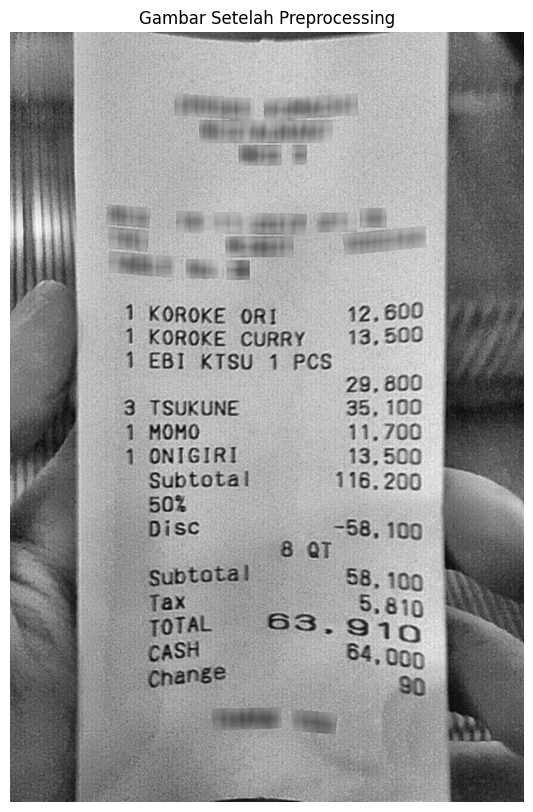

In [18]:
import os
import easyocr
# Path gambar
image_path = "D:\Documents\Kuliah\Semester 5\Studi Independen\capstone\output_images\image_1.png"

# Load gambar
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocessing
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_img = clahe.apply(image)
# Step 2 (Corrected): Sharpen the image
kernel_sharpening = np.array([[-1, -1, -1], 
                               [-1,  9, -1],
                               [-1, -1, -1]])
sharpened_img = cv2.filter2D(enhanced_img, -1, kernel_sharpening)
blurred_img = cv2.GaussianBlur(sharpened_img, (5, 5), 0)
# _, binary_img = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# OCR menggunakan EasyOCR
reader = easyocr.Reader(['id'], gpu=False)
results = reader.readtext(blurred_img)

# Cari baris yang mengandung kata "TOTAL"
threshold = 100
lines_with_total = []

for detection in results:
    text = detection[1]
    if "TOTAL" in text.upper():
        lines_with_total.append(detection)

detected_lines = []
for line in lines_with_total:
    total_coords = line[0]
    total_y_center = (total_coords[0][1] + total_coords[2][1]) / 2

    line_texts = []
    for detection in results:
        coords = detection[0]
        y_center = (coords[0][1] + coords[2][1]) / 2
        if abs(total_y_center - y_center) < threshold:
            line_texts.append(detection[1])

    detected_lines.append(" ".join(line_texts))

# Tampilkan hasil
print("Baris yang mengandung kata 'TOTAL' dan teks sebaris:")
for idx, line in enumerate(detected_lines):
    print(f"Baris {idx + 1}: {line}")

# Visualisasi gambar hasil preprocessing
plt.figure(figsize=(10, 10))
plt.imshow(blurred_img, cmap='gray')
plt.axis("off")
plt.title("Gambar Setelah Preprocessing")
plt.show()

Using CPU. Note: This module is much faster with a GPU.


[
  {
    "words": [
      {
        "quad": {
          "x1": 225,
          "y1": 450,
          "x2": 368,
          "y2": 450,
          "x3": 368,
          "y3": 499,
          "x4": 225,
          "y4": 499
        },
        "is_key": 0,
        "row_id": 2119099,
        "text": "KOROKE"
      }
    ],
    "category": "menu.nm",
    "group_id": 3,
    "sub_group_id": 0
  },
  {
    "words": [
      {
        "quad": {
          "x1": 381,
          "y1": 457,
          "x2": 453,
          "y2": 457,
          "x3": 453,
          "y3": 497,
          "x4": 381,
          "y4": 497
        },
        "is_key": 0,
        "row_id": 2119100,
        "text": "ORI"
      }
    ],
    "category": "menu.nm",
    "group_id": 3,
    "sub_group_id": 0
  },
  {
    "words": [
      {
        "quad": {
          "x1": 562,
          "y1": 445,
          "x2": 703,
          "y2": 445,
          "x3": 703,
          "y3": 496,
          "x4": 562,
          "y4": 496
        },
        "i

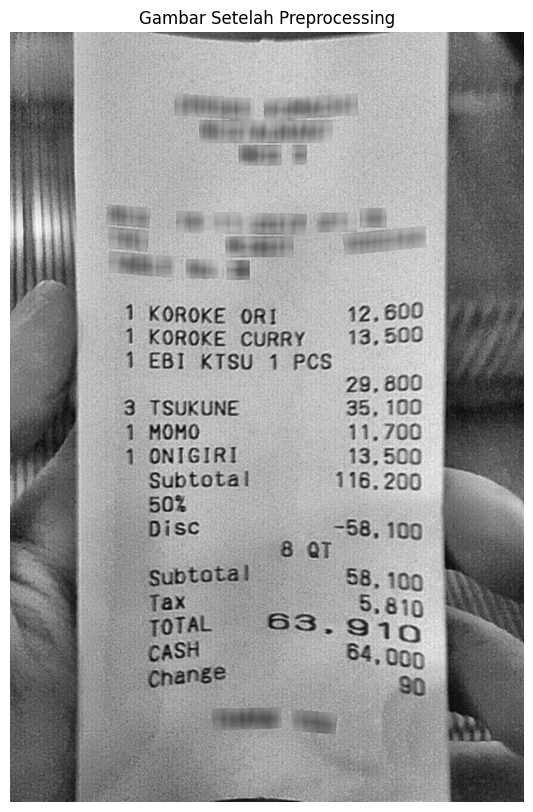

In [19]:
import os
import cv2
import numpy as np
import easyocr
import matplotlib.pyplot as plt

# Path gambar
image_path = "D:/Documents/Kuliah/Semester 5/Studi Independen/capstone/output_images/image_1.png"

# Load gambar
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocessing
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_img = clahe.apply(image)

# Sharpen the image
kernel_sharpening = np.array([[-1, -1, -1], 
                               [-1,  9, -1],
                               [-1, -1, -1]])
sharpened_img = cv2.filter2D(enhanced_img, -1, kernel_sharpening)
blurred_img = cv2.GaussianBlur(sharpened_img, (5, 5), 0)

# OCR menggunakan EasyOCR
reader = easyocr.Reader(['id'], gpu=False)
results = reader.readtext(blurred_img)

# Process OCR results into desired format
output_data = []
row_id_counter = 2119099  # Starting row_id
group_id = 3  # Example group_id for menus, increment as needed

for detection in results:
    coords, text, _ = detection
    x1, y1 = coords[0]
    x2, y2 = coords[2]
    
    word_data = {
        "quad": {
            "x1": int(x1),
            "y1": int(y1),
            "x2": int(x2),
            "y2": int(y1),
            "x3": int(x2),
            "y3": int(y2),
            "x4": int(x1),
            "y4": int(y2)
        },
        "is_key": 1 if text.upper() in ["TOTAL", "TAX", "GRAND", "TUNAI", "KEMBALI"] else 0,
        "row_id": row_id_counter,
        "text": text
    }
    
    category = "menu.nm"  # Default category
    if "TOTAL" in text.upper():
        category = "sub_total.subtotal_price" if "GRAND" not in text.upper() else "total.total_price"
    elif "TAX" in text.upper():
        category = "sub_total.tax_price"
    elif "GRAND" in text.upper():
        category = "total.total_price"
    elif "TUNAI" in text.upper():
        category = "total.cashprice"
    elif "KEMBALI" in text.upper():
        category = "total.changeprice"

    group_data = {
        "words": [word_data],
        "category": category,
        "group_id": group_id,
        "sub_group_id": 0
    }
    output_data.append(group_data)

    # Increment row_id for each word
    row_id_counter += 1

# Tampilkan hasil dalam format JSON
import json
print(json.dumps(output_data, indent=2))

# Visualisasi gambar hasil preprocessing
plt.figure(figsize=(10, 10))
plt.imshow(blurred_img, cmap='gray')
plt.axis("off")
plt.title("Gambar Setelah Preprocessing")
plt.show()


In [21]:
!pip install ipynb

In [25]:
from ipynb.fs.full.text_clasification import predict_stage1_and_stage2

ImportError: Could not import d:\Documents\Kuliah\Semester 5\Studi Independen\capstone\text_clasification.ipynb for ipynb.fs.full.text_clasification: not a valid ipynb file